In [29]:
import tensorflow as tf
import numpy as np
import base64, io, time, gym
import IPython, functools
import matplotlib.pyplot as plt
from tqdm import tqdm

In [30]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    print(e)

In [35]:
env = gym.make('CartPole-v0')

In [36]:
n_observations = env.observation_space
print("Environment has observation space =", n_observations)

Environment has observation space = Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)


In [37]:
n_actions = env.action_space.n
print("Number of possible actions that the agent can choose from =", n_actions)

Number of possible actions that the agent can choose from = 2


In [38]:
def create_cartpole_model():
  model = tf.keras.models.Sequential([
      # First Dense layer
      tf.keras.layers.Dense(units=32, activation='relu'),
      tf.keras.layers.Dense(units=n_actions, activation=None)
  ])
  return model

cartpole_model = create_cartpole_model()

In [39]:
def choose_action(model, observation, single=True):
  # add batch dimension to the observation if only a single example was provided
  observation = np.expand_dims(observation, axis=0) if single else observation

  # feed the observations through the model to predict the log 
  # probabilities of each possible action.
  logits = model.predict(observation)
  
  # Choose an action from the categorical distribution defined by the log 
  # probabilities of each possible action.
  action = tf.random.categorical(logits, num_samples=1)

  action = action.numpy().flatten()

  return action[0] if single else action

In [40]:
class Memory:
  def __init__(self): 
      self.clear()

  # Resets/restarts the memory buffer
  def clear(self): 
      self.observations = []
      self.actions = []
      self.rewards = []

  # Add observations, actions, rewards to memory
  def add_to_memory(self, new_observation, new_action, new_reward): 
      self.observations.append(new_observation)

      # update the list of actions with new action
      self.actions.append(new_action)

      # update the list of rewards with new reward
      self.rewards.append(new_reward)

# Helper function to combine a list of Memory objects into a single Memory.
#     This will be very useful for batching.
def aggregate_memories(memories):
  batch_memory = Memory()
  
  for memory in memories:
    for step in zip(memory.observations, memory.actions, memory.rewards):
      batch_memory.add_to_memory(*step)
  
  return batch_memory

# Instantiate a single Memory buffer
memory = Memory()

In [41]:
def normalize(x):
  x -= np.mean(x)
  x /= np.std(x)
  return x.astype(np.float32)

# Compute normalized, discounted, cumulative rewards (i.e., return)
# Arguments:
#   rewards: reward at timesteps in episode
#   gamma: discounting factor
# Returns:
#   normalized discounted reward
def discount_rewards(rewards, gamma=0.95): 
  discounted_rewards = np.zeros_like(rewards)
  R = 0
  for t in reversed(range(0, len(rewards))):
      # update the total discounted reward
      R = R * gamma + rewards[t]
      discounted_rewards[t] = R
      
  return normalize(discounted_rewards)

In [42]:
def compute_loss(logits, actions, rewards): 
  # compute the negative log probabilities
  neg_logprob = tf.nn.sparse_softmax_cross_entropy_with_logits(
     logits=logits, labels=actions)
  
  # scale the negative log probability by the rewards
  loss = tf.reduce_mean(neg_logprob * rewards)
  
  return loss

In [43]:
def train_step(model, optimizer, observations, actions, discounted_rewards):
  with tf.GradientTape() as tape:
      # Forward propagate through the agent network
      logits = model(observations)

      # compute the loss
      loss = compute_loss(logits, actions, discounted_rewards)

  # run backpropagation to minimize the loss using the tape.gradient method
  grads = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(grads, model.trainable_variables))

In [44]:
from IPython import display as ipythondisplay

class LossHistory:
  def __init__(self, smoothing_factor=0.0):
    self.alpha = smoothing_factor
    self.loss = []
  def append(self, value):
    self.loss.append( self.alpha*self.loss[-1] + (1-self.alpha)*value if len(self.loss)>0 else value )
  def get(self):
    return self.loss

class PeriodicPlotter:
  def __init__(self, sec, xlabel='', ylabel='', scale=None):

    self.xlabel = xlabel
    self.ylabel = ylabel
    self.sec = sec
    self.scale = scale

    self.tic = time.time()

  def plot(self, data):
    if time.time() - self.tic > self.sec:
      plt.cla()

      if self.scale is None:
        plt.plot(data)
      elif self.scale == 'semilogx':
        plt.semilogx(data)
      elif self.scale == 'semilogy':
        plt.semilogy(data)
      elif self.scale == 'loglog':
        plt.loglog(data)
      else:
        raise ValueError("unrecognized parameter scale {}".format(self.scale))

      plt.xlabel(self.xlabel); plt.ylabel(self.ylabel)
      ipythondisplay.clear_output(wait=True)
      ipythondisplay.display(plt.gcf())

      self.tic = time.time()

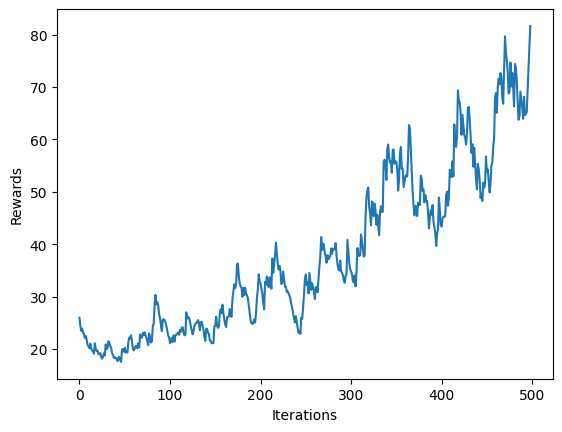

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━

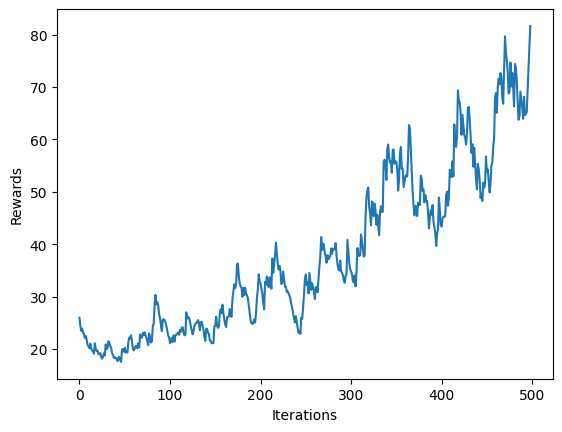

In [46]:
# Learning rate and optimizer
learning_rate = 1e-3
optimizer = tf.keras.optimizers.Adam(learning_rate)

# instantiate cartpole agent
cartpole_model = create_cartpole_model()

# to track our progress
smoothed_reward = LossHistory(smoothing_factor=0.9)
plotter = PeriodicPlotter(sec=2, xlabel='Iterations', ylabel='Rewards')

if hasattr(tqdm, '_instances'): tqdm._instances.clear() # clear if it exists
for i_episode in range(500):

  plotter.plot(smoothed_reward.get())

  # Restart the environment
  observation, _ = env.reset()
  memory.clear()

  while True:
      # using our observation, choose an action and take it in the environment
      action = choose_action(cartpole_model, observation)
      next_observation, reward, done, info, _ = env.step(action)
      # add to memory
      memory.add_to_memory(observation, action, reward)
      
      # is the episode over? did you crash or do so well that you're done?
      if done:
          # determine total reward and keep a record of this
          total_reward = sum(memory.rewards)
          smoothed_reward.append(total_reward)
          
          # initiate training - remember we don't know anything about how the 
          #   agent is doing until it has crashed!
          train_step(cartpole_model, optimizer, 
                     observations=np.vstack(memory.observations),
                     actions=np.array(memory.actions),
                     discounted_rewards = discount_rewards(memory.rewards))
          
          # reset the memory
          memory.clear()
          break
      # update our observatons
      observation = next_observation
